In [1]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import scipy.sparse as sp
import matplotlib.pyplot as plt

from abc import ABC

## Interpolation/Prolongation in 1D

In [2]:
# to be implemented
class Restriction(ABC):
    @staticmethod
    def restrict(x):
        pass
    
    @staticmethod
    def matrix(x):
        pass
    
# to be implemented
class Prolongation(ABC):
    @staticmethod
    def prolong(x):
        pass
    
    @staticmethod
    def matrix(x):
        pass

In [3]:
class FemProlongation(Prolongation):
    @staticmethod
    def prolong(x):
        return FemProlongation.matrix(x).dot(x)

    @staticmethod
    def matrix(x):
        l = len(x)
        data = np.tile((.5, 1, .5), l)
        rows = (np.array([0,1,2])[None] + np.array([2])[None] * np.arange(l)[:,None]).flatten()
        cols = (np.array([0,0,0])[None] + np.array([1])[None] * np.arange(l)[:,None]).flatten()
        return sp.coo_matrix((data, (rows, cols))).tocsr()

class WeightedRestriction(Restriction):
    @staticmethod
    def restrict(x):
        return WeightedRestriction.matrix(x).dot(x)

    @staticmethod
    def matrix(x):
        l = len(x) // 2
        data = np.tile((.25, .5, .25), l)
        cols = (np.array([0,1,2])[None] + np.array([2])[None] * np.arange(l)[:,None]).flatten()
        rows = (np.array([0,0,0])[None] + np.array([1])[None] * np.arange(l)[:,None]).flatten()
        return sp.coo_matrix((data, (rows, cols))).tocsr()

In [4]:
def jacobi(A, f, vh):
    r = f - A.dot(vh)
    return vh + sp.diags(1 / A.diagonal()).dot(r)

In [5]:
def multigrid(Ah, fh, smoother_info, hm, hm_threshold, restriction, prolongation, vh=None, gamma=1):
    """
    v1: pre-smoothing
    v2: post-smoothing
    smoother: (A, f, vh) -> vh'
    """
    smoother, v1, v2 = smoother_info
    
    if vh is None:
        vh = np.zeros_like(fh)
    
    for _ in range(v1):
        vh = smoother(Ah, fh, vh)
    
    if hm == hm_threshold:
        vh = np.linalg.solve(Ah, fh)
    else:
        f2h = restriction.restrict(fh - Ah.dot(vh))
        restricted_vh = restriction.restrict(vh)
        v2h = np.zeros_like(restricted_vh)
        
        pvh = prolongation.matrix(restricted_vh)
        rvh = restriction.matrix(vh)
        A2h = rvh.dot(Ah.dot(pvh.toarray()))
        for _ in range(gamma):
            v2h = multigrid(A2h, f2h, smoother_info, hm + 1, hm_threshold, 
                            restriction, prolongation, vh=v2h, gamma=gamma)
        vh += prolongation.prolong(v2h)
    
    for _ in range(v2):
        vh = smoother(Ah, fh, vh)
        
    return vh

## 1D Model problem

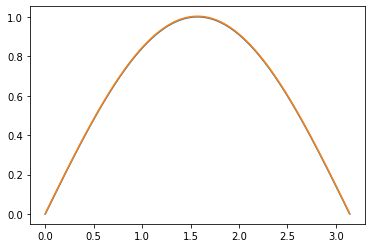

In [6]:
def homo_diffusion_problem(N, rhs_f, a=0, b=1):
    omega = np.linspace(a,b,N)
    h = omega[1] - omega[0]
    inverse_squared_h = 1/(h**2)
    A = np.diag(np.full(N-1, -inverse_squared_h), -1) + np.diag(np.full(N-1, -inverse_squared_h), 1) \
            + np.diag(np.full(N, 2*inverse_squared_h))
    A[[0,-1]] = 0
    A[0,0] = A[-1,-1] = 1
    return omega, A, rhs_f(omega)

omega, A, rhs = homo_diffusion_problem(1023, np.sin, b=np.pi)
out = multigrid(A, rhs, (jacobi, 3, 3), 0, 3, WeightedRestriction, FemProlongation)

plt.plot(omega, rhs)
plt.plot(omega, out);

## Interpolation/Prolongation in 2D

In [7]:
class Prolongation2D(Prolongation):    
    @staticmethod
    def prolong(x):
        return Prolongation2D.matrix(x).dot(x[0])

    @staticmethod
    def matrix(x):
        u, nx, ny = x
        return sp.kron(FemProlongation.matrix(np.empty(ny)), FemProlongation.matrix(np.empty(nx))).tocsr()

class InjectionRestriction2D(Restriction):
    @staticmethod
    def restrict(x):
        return InjectionRestriction2D.matrix(x).dot(x[0])

    @staticmethod
    def matrix(x):
        u, nx, ny = x
        nxp, nyp = (nx+1) // 2 - 1, (ny+1) // 2 - 1
        data = np.ones(nxp*nyp)
        rows = np.arange(nxp*nyp)
        cols = (np.linspace(0, nx, nxp, dtype=int, endpoint=False)[None] \
                + np.linspace(0, ny - 1, nyp, dtype=int)[:,None] * nx).flatten()
        return sp.coo_matrix((data, (rows, cols)), shape=(nxp*nyp, nx*ny))

## 2D Model problem

In [8]:
def homo_diffusion_problem_2d(omega, N, rhs_f):
    Nx, Ny = N
    
    data = (-np.ones((Ny-1)*Nx), -np.ones(Nx*Ny-1), 4*np.ones(Nx*Ny), \
            -np.ones(Nx*Ny-1), -np.ones((Nx-1)*Ny))
    A = sp.diags(data, (-Nx, -1, 0, 1, Ny), shape=(Nx*Ny, Nx*Ny), format='csr')
    
    x = np.linspace(*omega[0], Nx)
    y = np.linspace(*omega[1], Ny)

    hx = x[1] - x[0]
    hy = y[1] - y[0]
    
    X,Y = np.meshgrid(x, y)
    X = X.flatten()
    Y = Y.flatten()
    
    return (X,Y), A, rhs_f(X,Y)

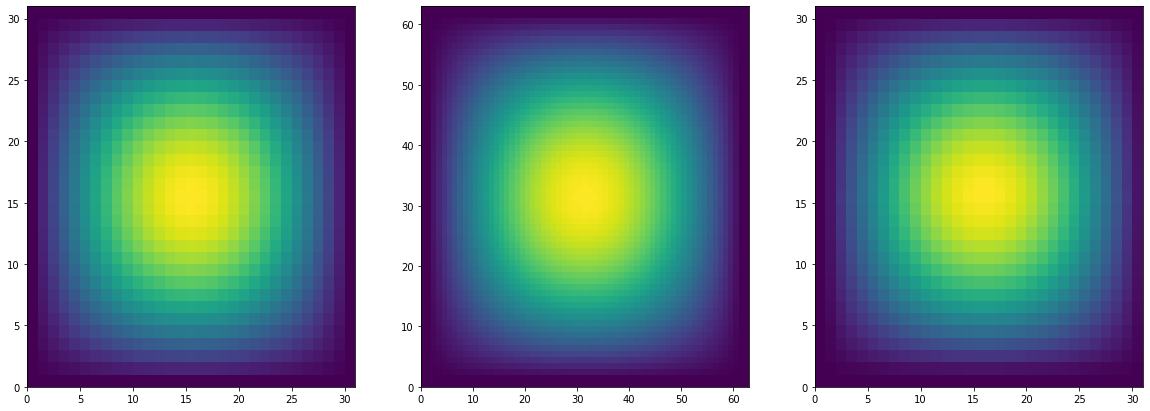

In [9]:
omega = np.zeros((2,2))
omega[[0,1],1] = np.pi
nx, ny = (31,31)

def f(x,y):
    return np.sin(x) * np.sin(y)

(X,Y), A, rhs = homo_diffusion_problem_2d(omega, (nx,ny), f)

plt.figure(figsize=(20,7))

plt.subplot(1,3,1)
plt.pcolormesh(f(X,Y).reshape(ny, nx))

plt.subplot(1,3,2)
u = Prolongation2D.prolong((f(X,Y), nx, ny))
plt.pcolormesh(u.reshape((ny+1)*2-1, (nx+1)*2-1))

plt.subplot(1,3,3)
plt.pcolormesh(InjectionRestriction2D.restrict((u, (nx+1)*2-1, (ny+1)*2-1)).reshape(ny, nx));